# Project Orange: IMDB reviews sentiment analysis

The purpose of the project is to build a model that would be able to classify the sentiment of a review of a movie and label if it has a positive or a negative sentiment. This way the opinions could be classified to be either negative or positive, while the medium sentiment is excluded from the analysis. 
Thus, the goal is to assign and weight either a positive or a negative connotation associated with each word or group of words. In addition, no weight is intended to be assigned to the words that are commonly used is sentence formation and that do not reflect any emotion. 

# 1. Required Libraries

## Setup

Install all required dependencies for the future analysis in the current Jupyter kernel.

In [278]:
import sys
!{sys.executable} -m pip install -U scikit-learn spacy pandas seaborn sklearn
!{sys.executable} -m spacy download en_core_web_sm
!{sys.executable} -m pip install pyenchant

Requirement already up-to-date: scikit-learn in c:\users\cyrill\anaconda3\lib\site-packages (0.22)
Requirement already up-to-date: spacy in c:\users\cyrill\anaconda3\lib\site-packages (2.2.3)
Requirement already up-to-date: pandas in c:\users\cyrill\anaconda3\lib\site-packages (0.25.3)
Requirement already up-to-date: seaborn in c:\users\cyrill\anaconda3\lib\site-packages (0.9.0)
Requirement already up-to-date: sklearn in c:\users\cyrill\anaconda3\lib\site-packages (0.0)
[+] Download and installation successful


You can now load the model via spacy.load('en_core_web_sm')
  Using cached https://files.pythonhosted.org/packages/9e/54/04d88a59efa33fefb88133ceb638cdf754319030c28aadc5a379d82140ed/pyenchant-2.0.0.tar.gz


    ERROR: Complete output from command python setup.py egg_info:
    ERROR: Traceback (most recent call last):
      File "<string>", line 1, in <module>
      File "C:\Users\Cyrill\AppData\Local\Temp\pip-install-npemp53d\pyenchant\setup.py", line 212, in <module>
        import enchant
      File "C:\Users\Cyrill\AppData\Local\Temp\pip-install-npemp53d\pyenchant\enchant\__init__.py", line 92, in <module>
        from enchant import _enchant as _e
      File "C:\Users\Cyrill\AppData\Local\Temp\pip-install-npemp53d\pyenchant\enchant\_enchant.py", line 145, in <module>
        raise ImportError(msg)
    ImportError: The 'enchant' C library was not found. Please install it via your OS package manager, or use a pre-built binary wheel from PyPI.
    ----------------------------------------
ERROR: Command "python setup.py egg_info" failed with error code 1 in C:\Users\Cyrill\AppData\Local\Temp\pip-install-npemp53d\pyenchant\


In [279]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import spacy


from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, average_precision_score
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve


%matplotlib inline
sns.set_style("darkgrid")
sp = spacy.load('en_core_web_sm')

# 2. EDA

### Import dataset

In [280]:
data = pd.read_csv("../data/imdb_dataset.csv") 

# Keep the first 100 elements to reduce the load on cpu
data=data[:50]
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [281]:
# Base rate, delete later
a=data[data["sentiment"]=="positive"].shape
b=data[data["sentiment"]=="negative"].shape
base_rate=max(a[0], b[0])/data.shape[0]
print("The base rate is "+ str(base_rate))

The base rate is 0.54


## Cleaning

#### Text to lowercase

In [282]:
def to_lower(this_review):
    this_review=this_review.lower()
    return this_review

#### Remove HTML elements

In [283]:
REMOVE_HTML = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

def remove_html(review):
    return REMOVE_HTML.sub(" ", review) 

#### Identify and remove entities

In [284]:
def recognize_it(this_review):
    doc=sp(this_review)
    
    for i in doc.ents:
            i=str(i)
            this_review=this_review.replace(" "+i,"")
    return this_review

#### Lemmatization

In [285]:
# Implementing lemmatization
def lemmatize_it(this_review):
    filtered_sent=[]

    #  "nlp" Object is used to create documents with linguistic annotations.
    lem = sp(this_review)
    
   # finding lemma for each word
    for word in lem:
        filtered_sent.append(word.lemma_)
    return filtered_sent

#### Tokenization (not used)

In [286]:
# "nlp" Object is used to create documents with linguistic annotations.
nlp = spacy.lang.en.English()

def tokenize_review(this_review):
    my_doc = nlp(this_review)
    
    # Create list of word tokens
    token_list = []
    for token in my_doc:
        token_list.append(token.text)
    return token_list

#### Adapt spacy stopwords list to our topic

In [287]:
#print stopword list from spacy
spacy_stopwords = list(spacy.lang.en.stop_words.STOP_WORDS)

remove_from_stopwordlist=["n't", "most", "much", "never", "no", "not", "nothing", "n‘t", "n’t", "really", "top", "very", "well"]
for word in spacy_stopwords:
    if word in remove_from_stopwordlist:
         spacy_stopwords.remove(word)

add_to_stopwords=['.', ',', '!', '?', ':', '&', '...', '(', ')','-', '/', '"', ';', '-PRON-', ' ', "'", '....', '  ', '*']
for word in add_to_stopwords:
    spacy_stopwords.append(word)

####  Remove stopwords and punctuation

In [288]:
def eliminate_stopwords(this_review):
    
    filtered_sent=[]

    #  "nlp" Object is used to create documents with linguistic annotations.
    doc = this_review
    
    # filtering stop words
    for word in doc:
        if word not in spacy_stopwords:
            filtered_sent.append(word)
    return filtered_sent
    

## Final dataset

In [289]:
def MASTA_CLEAN(this_review):
    this_review=to_lower(this_review)
    this_review=remove_html(this_review)
    this_review=recognize_it(this_review)
    this_review=lemmatize_it(this_review)
    this_review=eliminate_stopwords(this_review)
    return this_review

In [327]:
data['mastacleaned_reviews'] = data['review'].map(MASTA_CLEAN)
data.head()

,review,sentiment,mastacleaned_reviews
0,One of the other reviewers has mentioned that ...,positive,"[reviewer, mention, watch, oz, episode, hook, ..."
1,A wonderful little production. <br /><br />The...,positive,"[wonderful, little, production, filming, techn..."
2,I thought this was a wonderful way to spend ti...,positive,"[think, wonderful, way, spend, time, hot, sit,..."
3,Basically there's a family where a little boy ...,negative,"[basically, family, little, boy, jake, think, ..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"[petter, love, time, money, visually, stunning..."


In [337]:
pos=data.loc[data['sentiment'] == 'positive', ['mastacleaned_reviews']]
neg=data.loc[data['sentiment'] == 'negative', ['mastacleaned_reviews']]

pos_wordlist=[]
neg_wordlist=[]
for i in pos['mastacleaned_reviews']:
    pos_wordlist=pos_wordlist + i
print(pos_wordlist)
for j in neg['mastacleaned_reviews']:
    neg_wordlist=neg_wordlist + j
print(neg_wordlist)

['reviewer', 'mention', 'watch', 'oz', 'episode', 'hook', 'right', 'exactly', 'happen', 'thing', 'strike', 'oz', 'brutality', 'unflinche', 'scene', 'violence', 'set', 'right', 'word', 'trust', 'not', 'faint', 'hearted', 'timid', 'pull', 'no', 'punch', 'regard', 'drug', 'sex', 'violence', 'hardcore', 'classic', 'use', 'word', 'oz', 'nickname', 'oswald', 'maximum', 'security', 'state', 'penitentary', 'focus', 'mainly', 'emerald', 'city', 'experimental', 'section', 'prison', 'cell', 'glass', 'face', 'inward', 'privacy', 'not', 'high', 'agenda', 'city', 'home', '..', 'aryan', 'latinos', 'scuffle', 'death', 'stare', 'dodgy', 'dealing', 'shady', 'agreement', 'never', 'far', 'away', 'main', 'appeal', 'fact', 'not', 'dare', 'forget', 'pretty', 'picture', 'paint', 'mainstream', 'audience', 'forget', 'charm', 'forget', 'romance', 'oz', 'not', 'mess', 'episode', 'strike', 'nasty', 'surreal', 'not', 'ready', 'watch', 'develop', 'taste', 'oz', 'accustomed', 'high', 'level', 'graphic', 'violence', '

['basically', 'family', 'little', 'boy', 'jake', 'think', 'zombie', 'closet', 'parent', 'fight', 'time', 'movie', 'slow', 'soap', 'opera', 'suddenly', 'decide', 'rambo', 'kill', 'zombie', 'ok', 'film', 'decide', 'thriller', 'drama', 'drama', 'movie', 'watchable', 'parent', 'divorce', 'argue', 'like', 'real', 'life', 'closet', 'totally', 'ruin', 'film', 'expect', 'boogeyman', 'similar', 'movie', 'instead', 'watch', 'drama', 'meaningless', 'thriller', 'spot', 'well', 'play', 'parent', 'descent', 'dialog', 'shot', 'ignore', 'amazing', 'fresh', 'innovative', 'idea', 'air', '7', '8', 'year', 'brilliant', 'thing', 'drop', 'not', 'really', 'funny', 'anymore', 'continue', 'decline', 'complete', 'waste', 'time', 'truly', 'disgraceful', 'far', 'fall', 'writing', 'painfully', 'bad', 'performance', 'bad', 'not', 'mildly', 'entertaining', 'respite', 'guest', 'host', 'probably', 'not', 'air', 'find', 'hard', 'believe', 'creator', 'hand', 'select', 'original', 'cast', 'choose', 'band', 'hack', 'follo

In [324]:
# Process all reviews and save to csv
#data = pd.read_csv("../data/imdb_dataset.csv") 

#data['review'] = data['review'].map(MASTA_CLEAN)

#data.to_csv("../data/cleaned_dataset.csv", index=False)


In [293]:
#data = pd.read_csv("../data/cleaned_dataset.csv") 
#data.head()

# 3. Analysis

#### Splitting the dataset into training and test sets

In [294]:
X = data['review'] # the features we want to analyze, we can play with others too
y = data['sentiment'] # the labels, or answers, we want to test against

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)

### 3.1 Logistic Model

In [295]:
classifier = LogisticRegression(solver="lbfgs")

count_vector = CountVectorizer(tokenizer = MASTA_CLEAN, ngram_range = (1,2))

# Create pipeline using Bag of Words
pipe = Pipeline([('vectorizer', count_vector), ('classifier', classifier)])

# Fit Model
pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function MASTA_CLEAN at 0x000001F9B2248378>,
                                 vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
         

#### Results

In [296]:
predicted_train = pipe.predict(X_train)
predicted_test = pipe.predict(X_test)

# train accuracy
print("Train set accuracy: " + str(pipe.score(X_train, y_train)))
# test accuracy
print("Test set accuracy is: " + str(pipe.score(X_test, y_test)))
print("Train set precision: " + str(metrics.precision_score(y_train, predicted_train, pos_label="positive")))
print("Train set recall: " +  str(metrics.recall_score(y_train, predicted_train, pos_label="positive")))
print("Test set precision: " + str(metrics.precision_score(y_test, predicted_test, pos_label="positive")))
print("Test set recall: " + str(metrics.recall_score(y_test, predicted_test, pos_label="positive")))

Train set accuracy: 1.0
Test set accuracy is: 0.5
Train set precision: 1.0
Train set recall: 1.0
Test set precision: 1.0
Test set recall: 0.16666666666666666


#### Confusion matrix

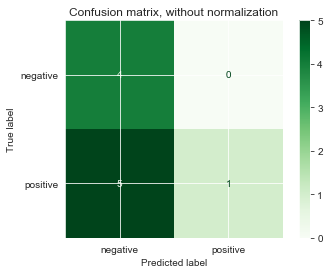

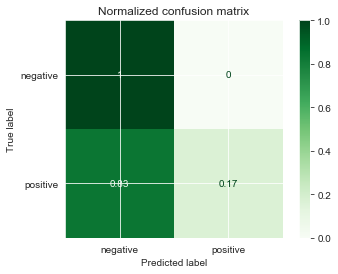

In [297]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(pipe, X_test, y_test, cmap=plt.cm.Greens, normalize=normalize)
    disp.ax_.set_title(title)

#### Precision Recall Curve


Average precision-recall score: 0.84


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.84')

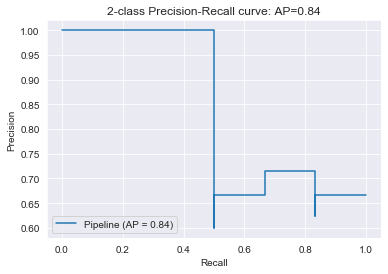

In [298]:
y_score = pipe.decision_function(X_test)
average_precision = average_precision_score(y_test, y_score, pos_label="positive")

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

disp = plot_precision_recall_curve(pipe, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

### 3.2 Decision Trees

In [299]:
X = count_vector.fit_transform(data['review'])
y = data['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)

In [300]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=2)
tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [301]:
tree.score(X_test,y_test)

0.6

In [302]:
tree.get_depth()

2

#### Tuning the depth of the tree

In [303]:
scores = []
for d in range(1, 21):
    test_tree = DecisionTreeClassifier(criterion='entropy', max_depth=d)
    test_tree.fit(X_train, y_train)
    scores.append(test_tree.score(X_test, y_test))

Text(0.5, 0, 'depth')

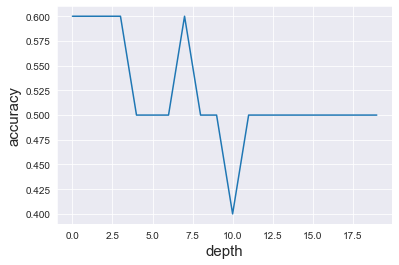

In [304]:
plt.plot(scores)
plt.ylabel('accuracy', fontsize=15)
plt.xlabel('depth', fontsize=15)

In [305]:
np.argmax(scores)

0

#### Confusion matrix

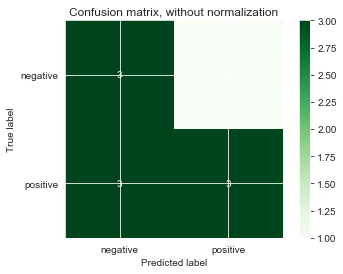

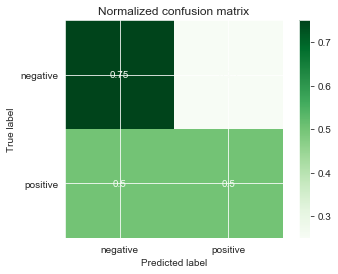

In [306]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(tree, X_test, y_test, cmap=plt.cm.Greens, normalize=normalize)
    disp.ax_.set_title(title)

 We need to have: 
* Precision & Recall for all methods 
* Precision-Recall curve 
* Cross-validation for all methods 


###  3.3 KNN Classification

In [307]:
knn = KNeighborsClassifier(n_neighbors= 10, weights='uniform') #here we can change the K-neighbors

In [308]:
X = count_vector.fit_transform(data['review'])
y = data['sentiment']

In [309]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)

In [310]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [311]:
knn.score(X_test, y_test)

0.4

#### Confusion matrix

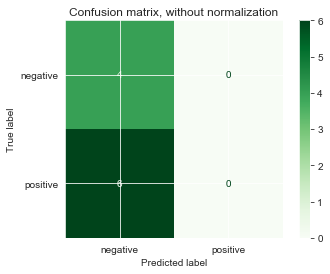

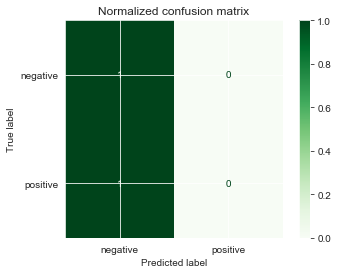

In [312]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(knn, X_test, y_test, cmap=plt.cm.Greens, normalize=normalize)
    disp.ax_.set_title(title)

### 3.4 Text similarity

In [313]:
stopwords = spacy_stopwords

# using default tokenizer 
count = CountVectorizer(ngram_range=(1,2), stop_words = None)
bow = count.fit_transform(data)

# 4. Conclusion and Recommendation

From the analysis shown above we can see that the best performing method of classification of the reviews into binary class positive/negative is Logistic Regression method......